# Régresion logistique

In [1]:
from Functions.Common_functions import *
import pandas as pd

### Chargement des données formatées

In [2]:
dataset_df = formate_dataset()
dataset_df.head()

Relative compactness Surface area  Wall area Roof area Overall height  \
0              2.06355     -1.59779  -0.269786  -1.42786              1   
1               2.0694     -1.71823  -0.422547  -1.47112              1   
2              2.03073     -1.75999  -0.340612  -1.55169              1   
3              2.01447     -1.72899  -0.581134  -1.40454              1   
4              1.30869     -1.34281 -0.0477237  -1.28699              1   

  Glazing area GAD : 0 GAD : 1 GAD : 2 GAD : 3 GAD : 4 GAD : 5 East North  \
0     -1.64028       1       0       0       0       0       0    0     1   
1     -1.83179       1       0       0       0       0       0    1     0   
2     -1.76649       1       0       0       0       0       0    0     0   
3     -1.76117       1       0       0       0       0       0    0     0   
4     -1.81079       1       0       0       0       0       0    0     1   

  South West   Energy Energy efficiency  
0     0    0  34.2639                 B  
1     0    0  34.5898                 B  
2     1    0   38.778                 C  
3     0    1  37.9478                 C  
4     0    0  47.6759                 D

### Séparation du train set et du test set

In [3]:
from sklearn.model_selection import train_test_split, cross_val_predict
X_train, X_test, y_train_r, y_test_r = train_test_split(dataset_df[dataset_df.columns[0:16]], dataset_df['Energy'], test_size=0.20, random_state=42)
_, _, y_train_b, y_test_b = train_test_split(dataset_df[dataset_df.columns[0:16]], dataset_df['Energy efficiency'], test_size=0.20, random_state=42) 

Nous avons choisi d'utiliser que 20% des données dans le test set car nous n'avons pas énormément de données.

In [4]:
X_train.head()

Relative compactness Surface area  Wall area Roof area Overall height  \
60              0.531311    -0.745559 -0.0780456 -0.689514              1   
618              -1.1574      1.29257   0.534939   1.00118             -1   
346              0.84627      -1.0325  -0.700866 -0.666789              1   
294              1.23387     -1.18323   0.113668  -1.20972              1   
231             -1.02421      1.09848  0.0316101   1.05643             -1   

    Glazing area GAD : 0 GAD : 1 GAD : 2 GAD : 3 GAD : 4 GAD : 5 East North  \
60     -0.991289       0       1       0       0       0       0    0     1   
618      1.23737       0       0       1       0       0       0    0     0   
346     0.082403       0       0       1       0       0       0    0     0   
294     0.118502       0       1       0       0       0       0    0     0   
231     -1.02533       0       0       0       0       1       0    0     0   

    South West  
60      0    0  
618     1    0  
346     1    0  
294     1    0  
231     0    1

## Régression logistique sans pénalisation

Text(0.5, 1.0, 'Nombre de labels dans le train set')

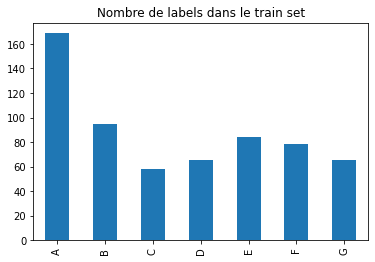

In [5]:
import matplotlib.pyplot as plt
y_train_b.value_counts().sort_index().plot.bar()
plt.title("Nombre de labels dans le train set")

Il est clair que le jeu de données est assez déséquilibré. La classe "A" est très réprésentée par rapport à la classe "C". Cependant, ce jeu de données est équilibré pour les classes "B", "E", "F" et "G", donc nous testerons l'équilibre initial des poids des classes par validation croisée pour créer nos classifieurs.

In [6]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

lr_clf = LogisticRegression(multi_class='multinomial', penalty='none', max_iter=10e10)        
grid = GridSearchCV(estimator=lr_clf, 
                    param_grid={'class_weight':['balanced', None]},
                   scoring='f1_macro')

grid.fit(X_train, y_train_b)


GridSearchCV(estimator=LogisticRegression(max_iter=100000000000.0,
                                          multi_class='multinomial',
                                          penalty='none'),
             param_grid={'class_weight': ['balanced', None]},
             scoring='f1_macro')

In [7]:
grid.best_params_

{'class_weight': None}

In [8]:
from sklearn.model_selection import cross_val_score
import numpy as np

clf = grid.best_estimator_
print('Affichage de la validation croisée pour 3 lots :')
print(cross_val_score(clf, X_train, y_train_b, cv=3))
print('Moyenne = %.2f' 
        % np.average(cross_val_score(clf, X_train, y_train_b, cv=3)))

Affichage de la validation croisée pour 3 lots :
[0.48292683 0.47804878 0.5245098 ]
Moyenne = 0.50


In [9]:
grid.score(X_train, y_train_b)

0.5360222760935296

## Test

In [10]:
print('Coefficient de determination: %.2f'
      % grid.best_estimator_.score(X_test, y_test_b))

Coefficient de determination: 0.55


In [11]:
from sklearn.metrics import classification_report

y_test_pred = grid.best_estimator_.predict(X_test)
# Print the precision and recall, among other metrics
print(classification_report(y_test_b, y_test_pred, digits=3))

              precision    recall  f1-score   support

           A      0.761     0.897     0.824        39
           B      0.333     0.429     0.375        14
           C      0.727     0.364     0.485        22
           D      0.353     0.429     0.387        14
           E      0.462     0.480     0.471        25
           F      0.476     0.417     0.444        24
           G      0.533     0.500     0.516        16

    accuracy                          0.552       154
   macro avg      0.521     0.502     0.500       154
weighted avg      0.564     0.552     0.546       154



L'overfitting est très faible sur ce model donc on ne pourra pas beaucoup l'améliorer en ajoutant une pénalité. 

### Analyse d'erreurs

<Figure size 360x360 with 0 Axes>

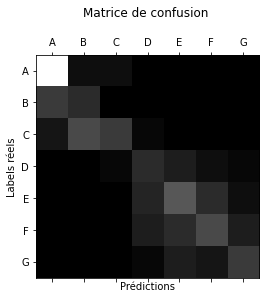

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
from Functions.Classification_Functions import *

conf_mx = compute_conf_matrix(estimator=grid.best_estimator_, X=X_test, y=y_test_b)
display_conf_matrix(conf_mx)

<Figure size 360x360 with 0 Axes>

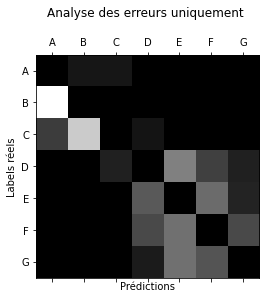

In [13]:
plot_error_analysis(conf_mx)

The model is confusing particularly the B labels with the A.

## Régression logistique avec pénalisation


### Pénalisation l1

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

params = {'C': np.linspace(0, 0.5, 100), 'penalty': ['l1'], 'solver': ['saga', 'liblinear'], 'class_weight': ['balanced', None]}

search_l1 = GridSearchCV(estimator=LogisticRegression(solver='saga', max_iter=10e7, class_weight='balanced', n_jobs=-1),
             param_grid=params,
             scoring='f1_macro',
             cv=3)

search_l1.fit(X_train, y_train_b)
search_l1.best_params_

{'C': 0.2474747474747475,
 'class_weight': 'balanced',
 'penalty': 'l1',
 'solver': 'saga'}

In [15]:
scores_l1 = cross_val_score(search_l1.best_estimator_, X_train, y_train_b, scoring='f1_macro', cv=3)
scores_l1.mean()


0.5171936150326849

In [16]:
coef_variable = np.sum(search_l1.best_estimator_.coef_, axis=0)

print("La pénalisation l1 supprime " + str(sum(coef_variable != 0)) + 
      " variables et en supprime " +  str(sum(coef_variable == 0)) + ".")

La pénalisation l1 supprime 12 variables et en supprime 4.


In [17]:
plt.figure(figsize=(5, 5))
imp_coef = pd.Series(data= coef_variable, index=X_train.columns).sort_values()
plt.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title(u"Coefficients du modèle lasso \n")

Text(0.5, 1.0, 'Coefficients du modèle lasso \n')

### Pénalisation Enet

In [18]:
warnings.filterwarnings('ignore')

search_enet = GridSearchCV(estimator=LogisticRegression(solver='saga', max_iter=10e7, class_weight='balanced'),
             param_grid={'C': np.linspace(0, 0.2, 5), 'penalty': ['elasticnet'], 
                         'l1_ratio' : [0.1, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]},
             scoring='f1_macro',
             cv=3)

search_enet.fit(X_train, y_train_b)
print(search_enet.best_params_)

score_enet = cross_val_score(search_enet.best_estimator_, X_train, y_train_b, scoring='f1_macro', cv=3)
score_enet.mean()


{'C': 0.2, 'l1_ratio': 0.8, 'penalty': 'elasticnet'}


0.5043887428221688

In [19]:
coef_variable_enet = np.sum(search_enet.best_estimator_.coef_, axis=0)

print("La pénalisation Enet retient " + str(sum(coef_variable != 0)) + 
      " variables et en supprime " +  str(sum(coef_variable == 0)) + ".")

La pénalisation Enet retient 12 variables et en supprime 4.


Text(0.5, 1.0, 'Coefficients du modèle lasso \n')

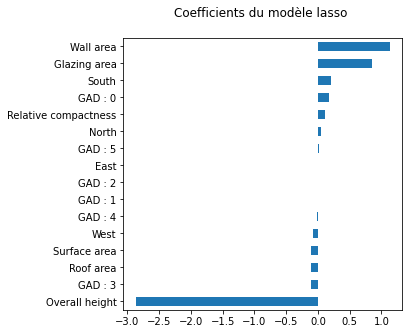

In [20]:
plt.figure(figsize=(5, 5))
imp_coef = pd.Series(data= coef_variable_enet, index=X_train.columns).sort_values()
plt.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title(u"Coefficients du modèle lasso \n")

### Pénalisation l2

In [21]:
search_l2 = GridSearchCV(estimator=LogisticRegression(solver='saga', max_iter=10000),
             param_grid={'C': [0.03, 0.1, 0.3, 0.7, 0.8, 0.9, 0.95, 0.98], 'penalty': ['l2'], 'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']},
             cv=3)

search_l2.fit(X_train, y_train_b)
print(search_l2.best_params_)

score_l2 = cross_val_score(search_l2.best_estimator_, X_train, y_train_b, scoring='f1_macro', cv=3)
score_l2.mean()

{'C': 0.8, 'penalty': 'l2', 'solver': 'newton-cg'}


0.46654202289458846

En regardant les f1 scores des différents modèle, on peut conclure que la pénalisation l2 est la plus performante pour notre jeu de données, c'est donc le modèle qu'on va tester sur notre jeu de test.

## Test

In [22]:
search_l1.best_estimator_.score(X_test, y_test_b)

0.5714285714285714

In [23]:
from sklearn.metrics import classification_report

y_test_pred = search_l1.best_estimator_.predict(X_test)
# Print the precision and recall, among other metrics
print(classification_report(y_test_b, y_test_pred, digits=3))

              precision    recall  f1-score   support

           A      0.825     0.846     0.835        39
           B      0.444     0.571     0.500        14
           C      0.643     0.409     0.500        22
           D      0.286     0.571     0.381        14
           E      0.529     0.360     0.429        25
           F      0.588     0.417     0.488        24
           G      0.550     0.688     0.611        16

    accuracy                          0.571       154
   macro avg      0.552     0.552     0.535       154
weighted avg      0.602     0.571     0.572       154



Nous nous intéressons particulièrement à l'accuracy de 56% et au f1 score macro average qui représente la moyenne des f1 scores des différentes classes. En effet, cette métrique nous donne une bonne idée de comment le classifiteur réagirait si le jeu de données était pas déséquilibré (ou s'il était déséquilibré différemment). Cette métrique nous indique mieux que les autres comment le classifieur prédirait n'importe quel label.

In [24]:
from sklearn.metrics import f1_score

# Sauvegarde des resultats
accuracy_lr = search_l1.best_estimator_.score(X_test, y_test_b)
y_pred_lr = search_l1.best_estimator_.predict(X_test)
f1_score_lr = f1_score(y_test_b, y_pred_lr, average='macro')

### Analyse des erreurs

<Figure size 360x360 with 0 Axes>

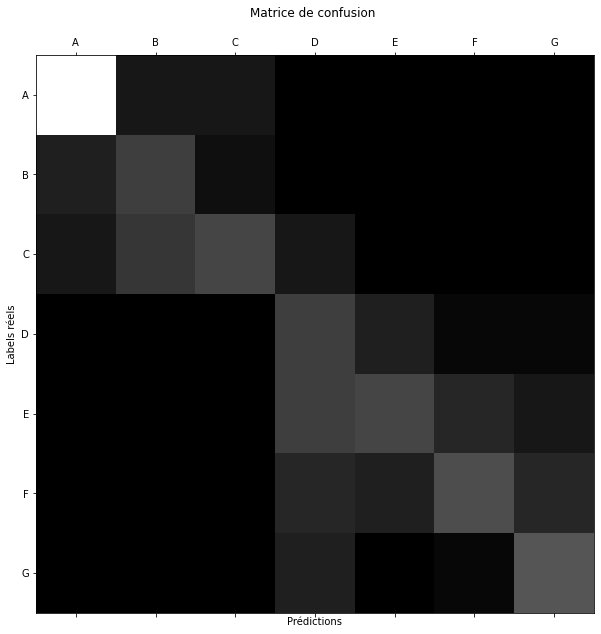

In [25]:
from Functions import Classification_Functions

y_test_pred = search_l1.best_estimator_.predict(X_test)
conf_mx = confusion_matrix(y_test_b, y_test_pred)
display_conf_matrix(conf_mx)

This model is more performant to detect A class than the other classes.

In [26]:
plot_error_analysis(conf_mx)

<Figure size 360x360 with 0 Axes>

On voit que le classifieur confond des "A" avec des "B" et "C". Il a aussi beaucoup de mal à bien classifier les labels "E", "F" et "G". On se rend compte cependant que le classifieur ne se trompe pas entre les groupes de classes "A", "B", "C" et "D", "E", "F", "G". Ce sont deux groupes qui apparaissent clairement dans la représentation ACP.

## Régression logistique avec duplication

La stratégie naïve consite à multiplier des individus de façon à obtenir un jeu de données tout à fait équilibré. Nous allons essayer cette méthode pour utiliser un ensemble de données accrues pour former une nouvelle régression logistique.

In [27]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled_b = ros.fit_resample(X= X_train, y=y_train_b)

<AxesSubplot:>

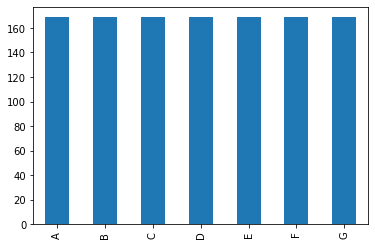

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
y_resampled_b.value_counts().sort_index().plot.bar()

### Naive oversampling

In [29]:
from sklearn.model_selection import train_test_split, cross_val_predict
X_res_train, _, y_res_train_b, _ = train_test_split(X_resampled, y_resampled_b, 
                                             test_size=0.20, random_state=42)

In [30]:
import warnings
warnings.filterwarnings('ignore')

search_enet = GridSearchCV(estimator=LogisticRegression(solver='saga', max_iter=1000000),
             param_grid={'C': np.linspace(0, 0.10, 50), 'penalty': ['elasticnet'], 
                         'l1_ratio' : [0.1, 0.3, 0.4, 0.5, 0.6, 0.7]},
             scoring = 'f1_score',
             cv=3)

search_l1.fit(X_res_train, y_res_train_b)
print(search_l1.best_params_)

score_l1 = cross_val_score(search_l1.best_estimator_, X_res_train, y_res_train_b, cv=5)
score_l1.mean()


{'C': 0.4646464646464647, 'class_weight': None, 'penalty': 'l1', 'solver': 'saga'}


0.5359287106655527

In [31]:
search_l1.best_estimator_.score(X_test, y_test_b)


0.5

In [32]:
from sklearn.metrics import classification_report

y_test_pred = search_l1.best_estimator_.predict(X_test)
# Print the precision and recall, among other metrics
print(classification_report(y_test_b, y_test_pred, digits=3))

              precision    recall  f1-score   support

           A      0.800     0.821     0.810        39
           B      0.263     0.357     0.303        14
           C      0.571     0.364     0.444        22
           D      0.258     0.571     0.356        14
           E      0.385     0.200     0.263        25
           F      0.500     0.417     0.455        24
           G      0.529     0.562     0.545        16

    accuracy                          0.500       154
   macro avg      0.472     0.470     0.454       154
weighted avg      0.527     0.500     0.499       154



Cette augmentation de données n'a pas bien fonctionné et nous n'avons pas amélioré la précision et le f1_score du premier classifieur de pénalisation l1.  

Nous allons donc mettre en œuvre une autre technique de sur-échantillonnage. En effet, nous allons mettre en œuvre le suréchantillonnage **SMOTENC** (Synthetic Minority Over-sampling Technique for Nominal and Continuous) qui est utile pour les ensembles de données contenant des caractéristiques numériques et qualitatives. 

SMOTE crée des échantillons basés sur l'algorithme K-means. Il fait toute distinction entre les échantillons faciles et difficiles à classer en utilisant la règle du plus proche voisin.

### SMOTE oversampling

In [33]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

model = Pipeline([
        ('sampling', SMOTE(random_state=12)),
        ('logistic', LogisticRegression())
    ])

grid = GridSearchCV(model, estimator=LogisticRegression(solver='saga', max_iter=10e100),
             param_grid={'logistic__C': np.linspace(0, 0.10, 50), 
                         'logistic__penalty': ['l1'], 
                         'logistic__solver': ['saga', 'liblinear'],
                         'logistic__class_weight': ['balanced', None]},
             cv=3)

grid.fit(X_train, y_train_b)
print(grid.best_params_)
grid.best_estimator_.score(X_test, y_test_b)

{'logistic__C': 0.0326530612244898, 'logistic__class_weight': None, 'logistic__penalty': 'l1', 'logistic__solver': 'saga'}


0.577922077922078

In [34]:
y_test_pred = grid.best_estimator_.predict(X_test)
# Print the precision and recall, among other metrics
print(classification_report(y_test_b, y_test_pred, digits=3))

              precision    recall  f1-score   support

           A      0.829     0.872     0.850        39
           B      0.533     0.571     0.552        14
           C      0.688     0.500     0.579        22
           D      0.286     0.571     0.381        14
           E      0.565     0.520     0.542        25
           F      0.600     0.250     0.353        24
           G      0.429     0.562     0.486        16

    accuracy                          0.578       154
   macro avg      0.561     0.550     0.535       154
weighted avg      0.612     0.578     0.576       154



Grâce au sur-échantillonnage synthétique, les résultats sont meilleurs que la technique naïve de sur-échantillonnage.
Cepednant, le sur-échantillonnage SMOTENC n'améliore pas le modèle initial avec la pénalisation de l1.

# Arbre de décision

In [35]:
from sklearn import tree
tree_clf = tree.DecisionTreeClassifier()
tree_clf.fit(X_train, y_train_b)


DecisionTreeClassifier()

Fonction qui permet de créer un Graphyz transformé en pdf pour voir l'arbre de décision sur le notebook.

In [36]:
from graphviz import Source
from sklearn.tree import export_graphviz

def graphviz(out_file_name, tree):
    export_graphviz(
    tree, 
    out_file="C:\\Users\\User\\Documents\\Valdom\\ML\\Projet\\Python\\Graphiz\\"+out_file_name+".dot",
    feature_names=X_train.columns,
    class_names=tree_clf.classes_,
    rounded=True,
    filled= True
    )
    print("Graphiz créé")
    
graphviz(out_file_name="full_tree", tree=tree_clf)

Graphiz créé


In [37]:
from IPython.display import IFrame
IFrame('Graphiz\\full_tree.pdf', width=1000, height=300)

In [38]:
from sklearn.model_selection import cross_val_score
import numpy as np

print('Affichage de la validation croisée pour 3 lots :')
print(cross_val_score(tree_clf, X_train, y_train_b, cv=3))
print('Moyenne = %.2f' 
        % np.average(cross_val_score(tree_clf, X_train, y_train_b, cv=3)))

Affichage de la validation croisée pour 3 lots :
[0.53658537 0.5804878  0.53921569]
Moyenne = 0.56


**Mémo :** Pour transformer un Graphyz en pdf, tapper la commande :
**dot -Tpdf Graphiz/full_tree.dot -o Graphiz/full_tree.pdf**

### Tree pruning

Des valeurs élevées de ccp_alpha accroît le nombre de nœuds élagués. En effet, l'accroissement du cpp_alpha augmente le nombre minimum d'échantillons requis dans un noeud feuille et diminue la profondeur maximale de l'arbe.

In [39]:
path = tree_clf.cost_complexity_pruning_path(X_train, y_train_b)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

Text(0.5, 1.0, 'Impureté des feuilles vs alpha effectif dans le training set')

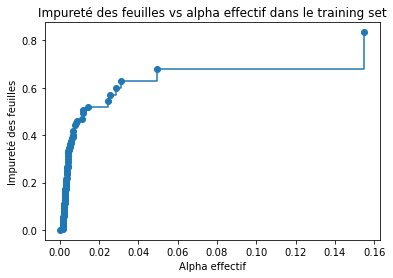

In [40]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(ccp_alphas, impurities, marker='o', drawstyle="steps-post")

ax.set_xlabel("Alpha effectif")
ax.set_ylabel("Impureté des feuilles")
ax.set_title("Impureté des feuilles vs alpha effectif dans le training set")


Plus l'alpha augmente, plus l'arbre est taillé, ce qui augmente l'impureté totale de ses feuilles.

In [41]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = tree.DecisionTreeClassifier(ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train_b)
    clfs.append(clf)
print("Le nombre de noeuds dans le dernier arbre est : {} avec ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))
print("Le nombre de noeuds dans l'avant-dernier arbre est : {} avec ccp_alpha: {}".format(
      clfs[-2].tree_.node_count, ccp_alphas[-2]))


Le nombre de noeuds dans le dernier arbre est : 3 avec ccp_alpha: 0.15498303192631324
Le nombre de noeuds dans l'avant-dernier arbre est : 3 avec ccp_alpha: 0.049471717725431796


Nous supprimons le dernier élément dans clfs et ccp_alphas, car c'est l'arbre trivial avec un seul nœud.
Nous montrons ici que le nombre de nœuds et la profondeur de l'arbre diminuent à mesure que le alpha augmente.

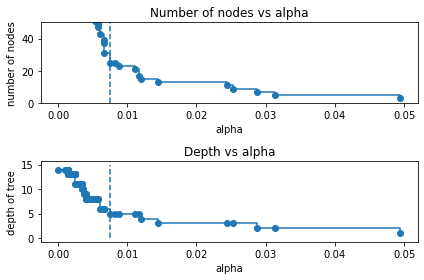

In [42]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)

ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[0].set_ylim([0, 50])
ax[0].vlines(0.0075, 0, 200, linestyles="--")

ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
ax[1].vlines(0.0075, 0, 15, linestyles="--")
fig.tight_layout()

### Accuracy vs alpha pour le training et le test set

In [43]:
from sklearn.model_selection import cross_val_score
train_scores = [clf.score(X_train, y_train_b) for clf in clfs]
test_scores = [clf.score(X_test, y_test_b) for clf in clfs]

cv_scores = []
for clf in clfs:
    cv_score = cross_val_score(estimator=clf, X=X_train, y=y_train_b, cv=3)
    cv_scores.append(cv_score.mean())


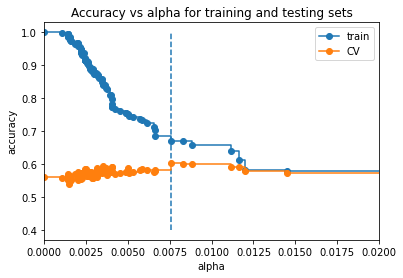

In [44]:
fig, ax = plt.subplots()
ax.set_xlim(0,0.02)
plt.vlines(0.0076, 0.4, 1, linestyles="--")
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, cv_scores, marker='o', label="CV",
        drawstyle="steps-post")
# ax.plot(ccp_alphas, test_scores, marker='o', label="test",
#         drawstyle="steps-post")
ax.legend()
plt.show()

Nous allons choisir un cpp_alpha de 0.0075 pour contruire notre arbre optimal. Cela correspond à une profondeur d'arbre de 5 et environ 30 noeuds. Nous allons maintenant vérifier si nous avons besoin d'équilibrer les poids initiaux des différentes classes dans ce modèle.

In [45]:
from sklearn.model_selection import GridSearchCV


opt_tree = GridSearchCV(estimator = tree.DecisionTreeClassifier(ccp_alpha=0.0075),
                        param_grid={'class_weight': ['balanced', None]},
                        scoring='f1_macro',
                        cv=3)
opt_tree.fit(X_train, y_train_b)
opt_tree.best_params_

{'class_weight': None}

Pour ce modèle, nous n'en avons pas besoin comme il est indiqué par la validation croisée, nous allons donc passer à la phase de test.

## Test

In [46]:
graphviz(out_file_name="test_tree", tree=opt_tree.best_estimator_)
print('Coefficient de determination: %.2f'
    % opt_tree.best_estimator_.score(X_test, y_test_b))

Graphiz créé
Coefficient de determination: 0.64


In [47]:
from IPython.display import IFrame
IFrame('Graphiz\\test_tree.pdf', width=1000, height=300)

In [48]:
print("Nous avons supprimé {} couches de profondeur pour obtenir un arbre optimal.".
      format((tree_clf.tree_.max_depth-opt_tree.best_estimator_.tree_.max_depth)))
print("Nous avons élagué {} noeuds pour obtenir un arbre de décision optimal.".
      format((tree_clf.tree_.node_count-opt_tree.best_estimator_.tree_.node_count)))


Nous avons supprimé 8 couches de profondeur pour obtenir un arbre optimal.
Nous avons élagué 296 noeuds pour obtenir un arbre de décision optimal.


Nous remarquons également sur les Graphyz affichés dans le notebook que l'arbre de décision optimal a été très élagué par rapport à l'arbre initial.

In [49]:
from sklearn.metrics import classification_report

y_test_pred = opt_tree.best_estimator_.predict(X_test)
print(classification_report(y_test_b, y_test_pred, digits=3))

              precision    recall  f1-score   support

           A      0.889     0.821     0.853        39
           B      0.346     0.643     0.450        14
           C      0.846     0.500     0.629        22
           D      0.667     0.571     0.615        14
           E      0.571     0.480     0.522        25
           F      0.516     0.667     0.582        24
           G      0.733     0.688     0.710        16

    accuracy                          0.643       154
   macro avg      0.653     0.624     0.623       154
weighted avg      0.687     0.643     0.652       154



In [50]:
# Sauvegarde des resultats
accuracy_dtc = opt_tree.best_estimator_.score(X_test, y_test_b)
f1_score_dtc = f1_score(y_test_b, y_test_pred, average='macro')

## Analyse d'erreurs

In [51]:
from Functions.Classification_Functions import *

conf_mx = compute_conf_matrix(opt_tree.best_estimator_, X_test, y_test_b)

<Figure size 360x360 with 0 Axes>

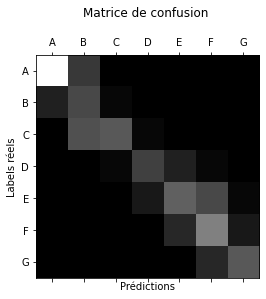

In [52]:
display_conf_matrix(conf_mx)

Le model classifie très bien les classes F et G comme nous pouvons le constater sur la matrice de confusion et le f1 score.

<Figure size 360x360 with 0 Axes>

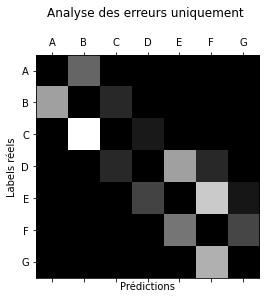

In [53]:
plot_error_analysis(conf_mx)

Ce modèle a du mal à bien classer la classe B. On peut remarquer que ce classifieur est proche d'avoir de très bons résultats car les échantillons mal classés sont presque toujours classés dans la classe la plus proche (on pourrait alors avoir de très bonnes prédictions en régression).

# Random forest

Nous allons tester les trois techniques connues de la litérature pour l'algorithme du RandomForest.

### Première technique : prendre des arbres  limités par une observation minimale par feuille (5 par défaut).

In [54]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np

random_forest = RandomForestClassifier(max_depth=None, oob_score=True, max_features='sqrt', n_jobs=-1)
clf_1 = GridSearchCV(estimator=random_forest, 
                   param_grid={'criterion': ('gini', 'entropy'),
                               'class_weight': ('balanced', 'balanced_subsample', None),
                               'min_samples_leaf': np.arange(1,7)})

clf_1.fit(X_train, y_train_b)

GridSearchCV(estimator=RandomForestClassifier(max_features='sqrt', n_jobs=-1,
                                              oob_score=True),
             param_grid={'class_weight': ('balanced', 'balanced_subsample',
                                          None),
                         'criterion': ('gini', 'entropy'),
                         'min_samples_leaf': array([1, 2, 3, 4, 5, 6])})

In [55]:
clf_1.best_params_

{'class_weight': 'balanced_subsample',
 'criterion': 'entropy',
 'min_samples_leaf': 3}

Le mode "balanced_subsample" est le même que "balanced", sauf que les poids sont calculés sur la base de l'échantillon bootstrap pour chaque arbre.
Les poids de chaque colonne de "y" sont multipliés.

In [56]:
clf_1.best_estimator_.oob_score_

0.6384364820846905

### Seconde technique : construire des arbres avec une profondeur limitée (q)

In [57]:
q = [3, 4, 5, 6, 7] # en général la profondeur limite est située en 3 et 6

clf_2 = GridSearchCV(estimator=random_forest, 
                   param_grid={'criterion': ('gini', 'entropy'),
                               'class_weight': ('balanced', 'balanced_subsample', None),
                               'max_depth': q})

clf_2.fit(X_train, y_train_b)

GridSearchCV(estimator=RandomForestClassifier(max_features='sqrt', n_jobs=-1,
                                              oob_score=True),
             param_grid={'class_weight': ('balanced', 'balanced_subsample',
                                          None),
                         'criterion': ('gini', 'entropy'),
                         'max_depth': [3, 4, 5, 6, 7]})

In [58]:
clf_2.best_params_

{'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': 7}

In [59]:
clf_2.best_estimator_.oob_score_

0.6335504885993485

### Troisième technique : contruire un arbre entier élagué par validation croisée

In [60]:
clf_3 = GridSearchCV(estimator=random_forest, 
                   param_grid={'criterion': ('gini', 'entropy'),
                               'class_weight': ('balanced', 'balanced_subsample'),
                               'ccp_alpha': np.linspace(start=0, stop=0.02, num=50)})

clf_3.fit(X_train, y_train_b)
clf_3.best_params_

{'ccp_alpha': 0.005306122448979592,
 'class_weight': 'balanced_subsample',
 'criterion': 'entropy'}

In [61]:
clf_3.best_estimator_.oob_score_

0.6319218241042345

Dans ce cas, en se fiant au out of bag score, la troisième technique fonctionne mieux, nous allons donc tester et évaluer ce modèle.

#### Feature importance

In [62]:
ft_importance = clf_3.best_estimator_.feature_importances_
columns_X = X_train.columns
pd.DataFrame(data= {'Feature': columns_X, 'Importance': ft_importance}).sort_values('Importance', ascending=False)

Feature  Importance
3              Roof area    0.175684
1           Surface area    0.169669
5           Glazing area    0.158401
0   Relative compactness    0.152079
2              Wall area    0.123086
4         Overall height    0.113655
6                GAD : 0    0.022823
7                GAD : 1    0.011551
11               GAD : 5    0.009879
8                GAD : 2    0.009814
12                  East    0.009554
9                GAD : 3    0.009420
14                 South    0.009156
13                 North    0.009016
15                  West    0.008986
10               GAD : 4    0.007227

Avec ce tableau des caractéristiques importantes, nous pouvons déduire que le modèle ne prend pas en compte les variables encodées en one-hot (variables qualitatives).

### Test

In [63]:
accuracy_rf = clf_3.best_estimator_.score(X_test, y_test_b)
accuracy_rf

0.6363636363636364

In [64]:
from sklearn.metrics import classification_report

y_pred_rf = clf_3.best_estimator_.predict(X_test)
# Sauvegarde des resultats
f1_score_rf = f1_score(y_test_b, y_pred_rf, average='macro')

print(classification_report(y_test_b, y_pred_rf, digits=3))

              precision    recall  f1-score   support

           A      0.810     0.872     0.840        39
           B      0.227     0.357     0.278        14
           C      0.900     0.409     0.563        22
           D      0.733     0.786     0.759        14
           E      0.640     0.640     0.640        25
           F      0.520     0.542     0.531        24
           G      0.667     0.625     0.645        16

    accuracy                          0.636       154
   macro avg      0.642     0.604     0.608       154
weighted avg      0.675     0.636     0.641       154



### Analyse des erreurs

<Figure size 360x360 with 0 Axes>

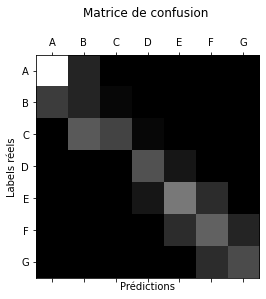

In [65]:
%matplotlib inline
import matplotlib.pyplot as plt
from Functions.Classification_Functions import *

conf_mx = compute_conf_matrix(estimator=clf_3.best_estimator_, X=X_test, y=y_test_b)
display_conf_matrix(conf_mx)

<Figure size 360x360 with 0 Axes>

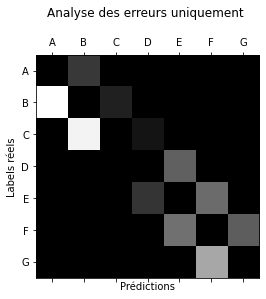

In [66]:
plot_error_analysis(conf_mx)

## Random forest with duplication

### Naive resampling

In [67]:
import warnings
warnings.filterwarnings('ignore')

model = Pipeline([
        ('sampling', RandomOverSampler(random_state=12)),
        ('clf', RandomForestClassifier())
    ])

grid = GridSearchCV(model, estimator=RandomForestClassifier(),
             param_grid={'clf__criterion': ('gini', 'entropy'),
                         'clf__class_weight': ('balanced', 'balanced_subsample', None),
                         'clf__ccp_alpha': np.linspace(start=0, stop=0.02, num=50)},
                         scoring='f1_macro',
                         cv=3)

clf_3.fit(X_resampled, y_resampled_b)
clf_3.best_estimator_.oob_score_

0.9222316145393068

In [68]:
from sklearn.metrics import classification_report

y_test_pred = clf_3.best_estimator_.predict(X_test)
# Print the precision and recall, among other metrics
print(classification_report(y_test_b, y_test_pred, digits=3))

              precision    recall  f1-score   support

           A      0.739     0.872     0.800        39
           B      0.214     0.214     0.214        14
           C      0.786     0.500     0.611        22
           D      0.786     0.786     0.786        14
           E      0.696     0.640     0.667        25
           F      0.519     0.583     0.549        24
           G      0.625     0.625     0.625        16

    accuracy                          0.643       154
   macro avg      0.623     0.603     0.607       154
weighted avg      0.649     0.643     0.640       154



### SMOTE

In [69]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

model = Pipeline([
        ('sampling', SMOTE(random_state=12)),
        ('clf', RandomForestClassifier(random_state=12))
    ])

grid = GridSearchCV(model, estimator=RandomForestClassifier(),
             param_grid={'clf__criterion': ('gini', 'entropy'),
                         'clf__class_weight': ('balanced', 'balanced_subsample', None),
                         'clf__ccp_alpha': np.linspace(start=0, stop=0.02, num=50)},
                         scoring='f1_macro',
                         cv=3)

grid.fit(X_train, y_train_b)
print(grid.best_params_)
grid.best_estimator_.score(X_test, y_test_b)

{'clf__ccp_alpha': 0.002857142857142857, 'clf__class_weight': 'balanced_subsample', 'clf__criterion': 'entropy'}


0.6103896103896104

In [70]:
from sklearn.metrics import classification_report

y_pred_rf_smote = grid.best_estimator_.predict(X_test)
# Print the precision and recall, among other metrics
print(classification_report(y_test_b, y_pred_rf_smote, digits=3))

              precision    recall  f1-score   support

           A      0.786     0.846     0.815        39
           B      0.176     0.214     0.194        14
           C      0.688     0.500     0.579        22
           D      0.733     0.786     0.759        14
           E      0.640     0.640     0.640        25
           F      0.455     0.417     0.435        24
           G      0.588     0.625     0.606        16

    accuracy                          0.610       154
   macro avg      0.581     0.575     0.575       154
weighted avg      0.616     0.610     0.610       154



Les techniques d'oversampling n'améliorent pas le résultat sur ce jeu de données avec le random forest classifieur.

# SVC

Nous allons maintenant tester des Support Vectors Classifiers sur notre jeu de données. Nous savons que ce classifieur très puissant est très sensible à deux paramètres : 
- Le kernel défini.
- La pénalité du terme d'erreur.

Pour cette raison, nous allons représenté le jeu de données en 2 dimensions (grâce à l'ACP que nous avons fait préalablement) pour tester et visualiser le kernel approprié.

### Transformation du train set en 2 composantes principales

In [71]:
import numpy as np

acp_df = pd.concat([X_train, y_train_b], axis=1)
acp_df = acp_df.drop(acp_df.columns[np.arange(6, 16)], axis = 1,)
acp_df.head()

Relative compactness Surface area  Wall area Roof area Overall height  \
60              0.531311    -0.745559 -0.0780456 -0.689514              1   
618              -1.1574      1.29257   0.534939   1.00118             -1   
346              0.84627      -1.0325  -0.700866 -0.666789              1   
294              1.23387     -1.18323   0.113668  -1.20972              1   
231             -1.02421      1.09848  0.0316101   1.05643             -1   

    Glazing area Energy efficiency  
60     -0.991289                 D  
618      1.23737                 C  
346     0.082403                 E  
294     0.118502                 E  
231     -1.02533                 A

Text(0.5, 1.0, 'ACP sur 2 composantes')

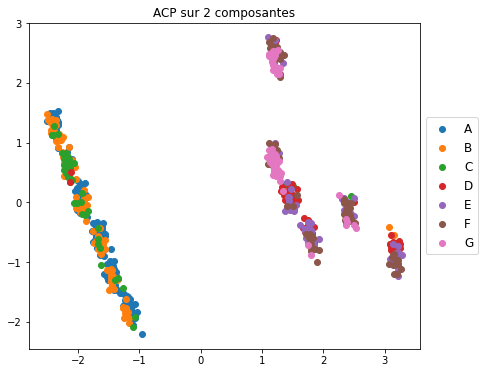

In [72]:
from sklearn.decomposition import PCA 
import matplotlib.pyplot as plt


pca = PCA(n_components=2, svd_solver="full")

X2D = pca.fit_transform(acp_df.drop(['Energy efficiency'], axis=1))

d = {"pc1": X2D[:, 0], "pc2": X2D[:, 1], "Energy_label": acp_df['Energy efficiency']}
X2D = pd.DataFrame(data=d)

plt.figure(figsize=(7,6))

def plot_classification_pca(subplot=plt):
    list_labels = ["A","B","C", "D", "E", "F", "G"]
    for value in list_labels:
        subplot.scatter(X2D["pc1"].where(X2D["Energy_label"]==value), X2D["pc2"].where(X2D["Energy_label"]==value),  label=value)
    subplot.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 12)
        
plot_classification_pca()
plt.title("ACP sur 2 composantes")

In [73]:
from sklearn.svm import SVC
# Création des variables pour faciliter le code
X_train_acp = X2D[['pc1','pc2']]
y_train_acp = X2D['Energy_label']
# Transformation des labels en chiffres pour pouvoir utiliser les SVC de l'API de sklearn
y_train_nb = y_train_acp.replace(["A","B","C", "D", "E", "F", "G"], np.arange(1,8))

In [74]:
from matplotlib.colors import LinearSegmentedColormap

# Fonctions qui vont nous permettre de plot les SVC en deux dimensions
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

# Fonction qui permet de plot les contours des classifieurs
def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

# Création des couleurs pour les différentes classes estimées par les classifieurs
def create_cmap():
    cmap_name = 'my_list'
    colors = ["cornflowerblue", "burlywood", "limegreen", "indianred", "mediumpurple", "chocolate", "pink"]  
    return LinearSegmentedColormap.from_list(cmap_name, colors, N=7)
    

In [75]:
X_train_acp[:5]

pc1       pc2
60   1.519067  0.090686
618 -2.167020  0.484960
346  1.799067 -0.717354
294  2.358307 -0.007625
231 -2.050742  0.180768

Nous allons commencé par tester un modèle linéaire du SVC.

### SVC linéaire

In [76]:
svc = SVC(class_weight='balanced', kernel='linear')

svc.fit(X_train_acp, y_train_nb)

SVC(class_weight='balanced', kernel='linear')

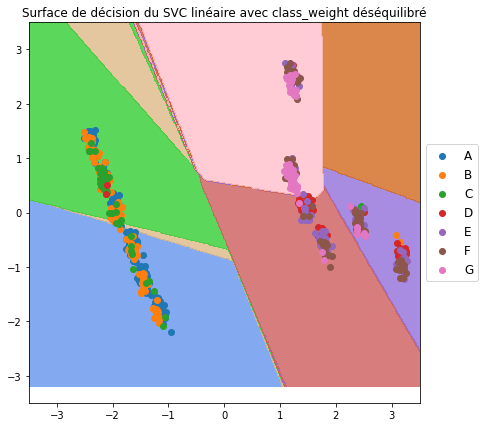

In [77]:
# Fonction qui va plot les différents SVC et les données avec 2 composantes principales
def plot_svc(model, title):
    fig, ax = plt.subplots(figsize=(7,7))# title for the plots
    
    # Set-up grid for plotting.
    X0, X1 = X_train_acp.pc1, X_train_acp.pc2
    xx, yy = make_meshgrid(X0, X1)

    plot_contours(ax, svc, xx, yy, cmap=create_cmap(), alpha=0.8)
    plot_classification_pca()

    ax.set_xlim(-3.5,3.5)
    ax.set_ylim(-3.5,3.5)
    ax.set_title(title)
    plt.show()
    
plot_svc(model=svc, title="Surface de décision du SVC linéaire avec class_weight déséquilibré")

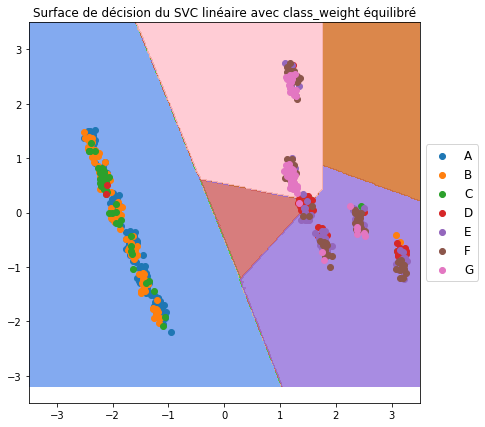

In [78]:
svc = SVC(kernel='linear')
svc.fit(X_train_acp, y_train_nb)

plot_svc(model=svc, title="Surface de décision du SVC linéaire avec class_weight équilibré")

Le SVC linéaire n'est pas très convaincant pour ce jeu de données, on va donc essayer d'autres noyaux.

### Autres kernels du SVC

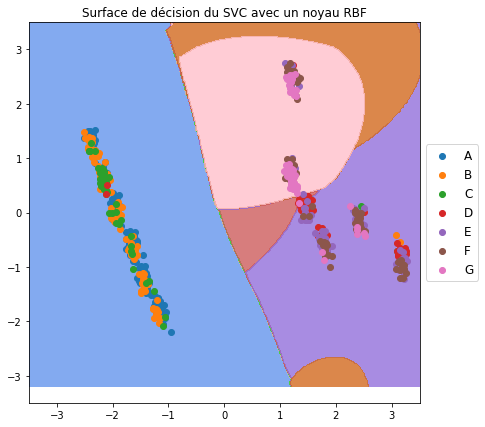

In [79]:
svc = SVC(kernel='rbf')
svc.fit(X_train_acp, y_train_nb)

plot_svc(model=svc, title="Surface de décision du SVC avec un noyau RBF")

En général, le noyau RBF est performant, c'est celui qui est utilisé par défaut dans la librairie sklearn.

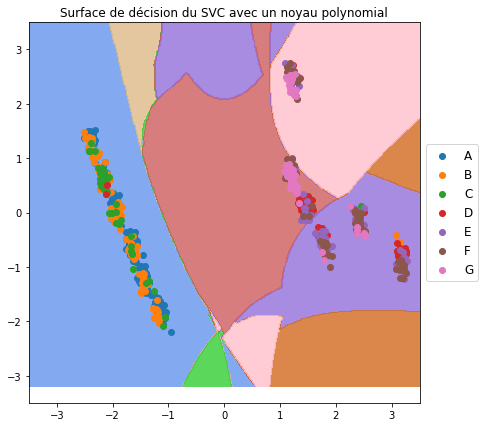

In [80]:
svc = SVC(kernel='poly', degree=3)
svc.fit(X_train_acp, y_train_nb)

plot_svc(model=svc, title="Surface de décision du SVC avec un noyau polynomial")

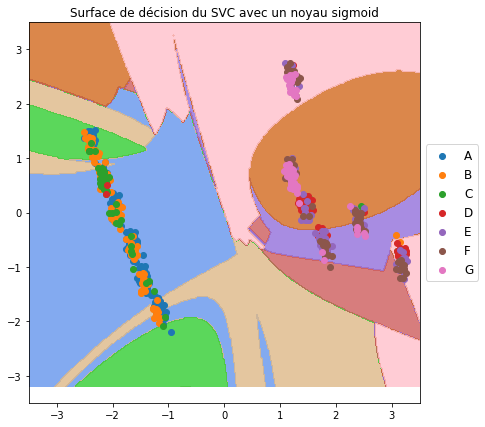

In [81]:
svc = SVC(kernel='sigmoid')
svc.fit(X_train_acp, y_train_nb)

plot_svc(model=svc, title="Surface de décision du SVC avec un noyau sigmoid")

Les différents SVC ont du mal à classifier les différentes classes avec un coût de 1.
On peut dire que la rbf et le polynôme du troisième degré SVC paraissent plus performants dans notre cas et nous allons les améliorer grâce aux hyperparamètres.

Nous allons mlaintenant essayer d'optimiser les hyperparamètres principaux en gardant les kernels polynomiaux et RBF.

### Gamma

Le gamma est un paramètre pour les hyperplans non linéaires. Plus la valeur gamma est élevée, plus il essaie de correspondre exactement à l'ensemble des données d'entraînement. Nous allons tester ce paramètre sur le SVC RBF.

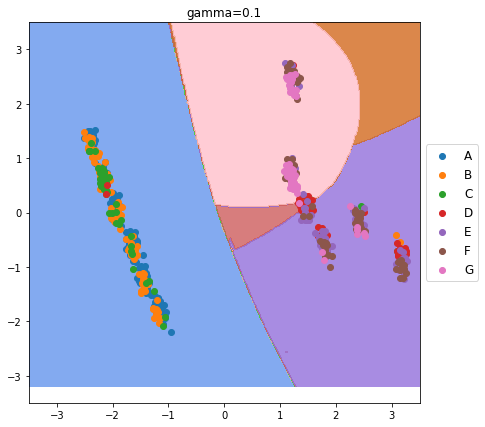

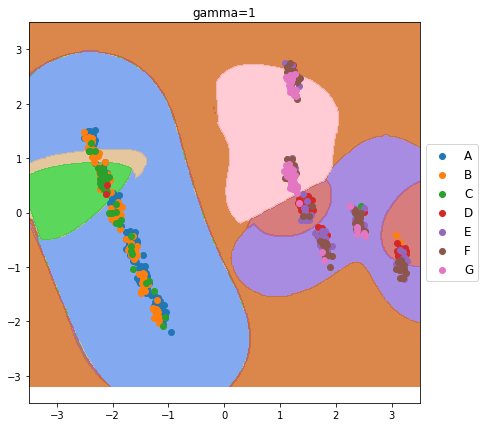

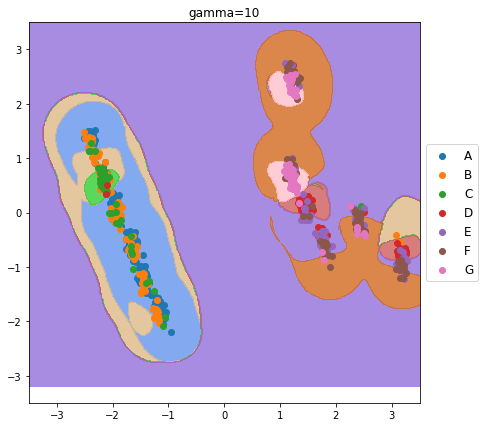

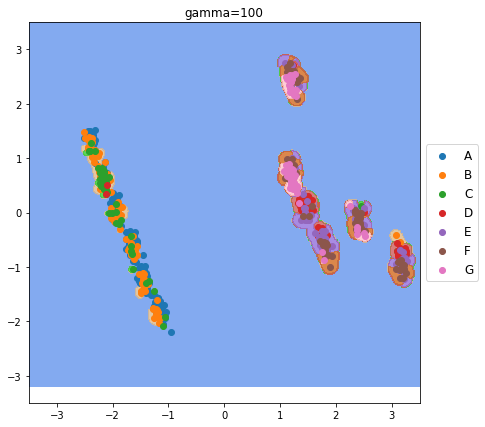

In [82]:
gammas = [0.1, 1, 10, 100]
for gamma in gammas:
   svc = SVC(kernel='rbf', gamma=gamma).fit(X_train_acp, y_train_nb)
   plot_svc(svc, 'gamma=' + str(gamma))

Le classifieur est bien adapté aux données lorsque gamma=10. Lorsque le gamma est égal à 100, il est évident que le modèle est surdimensionné. Nous pouvons essayer un gamma=10 avec le noyau polynomial.

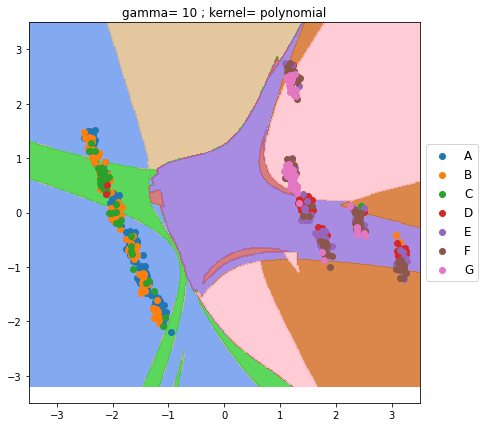

In [83]:
svc = SVC(kernel='poly', gamma=10).fit(X_train_acp, y_train_nb)
plot_svc(svc, 'gamma= 10 ; kernel= polynomial')

Ce modèle est moins performant que le noyau RBF mais nous allons essayer des degrès polynomiaux différents pour voir si nous pouvons pas améliorer ce classifieur.

Avant ceci, nous allons tester différentes pénalités pour le modèle avec le noyau RBF.

### Paramètre de pénalité

C est le paramètre de pénalité du terme d'erreur. Il contrôle le compromis entre une frontière de décision lisse et le classement correct des points de formation. Plus C est élevé, moins il y aura d'empiètement de la marge .

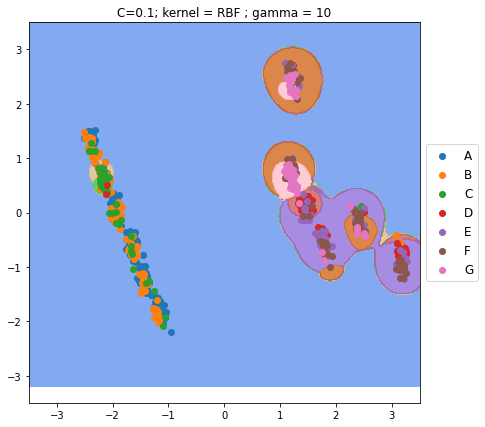

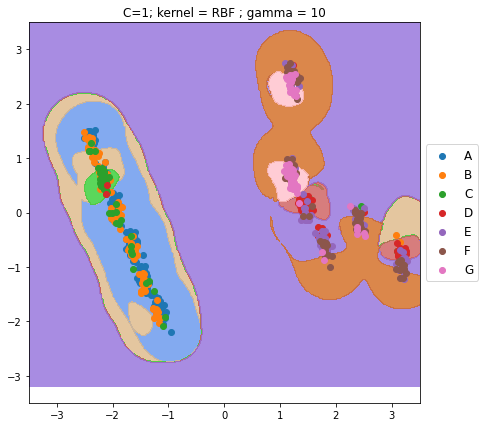

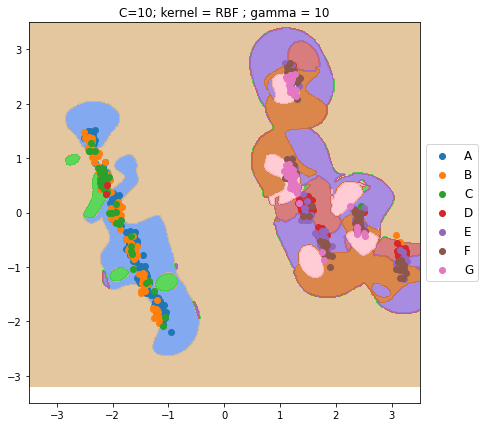

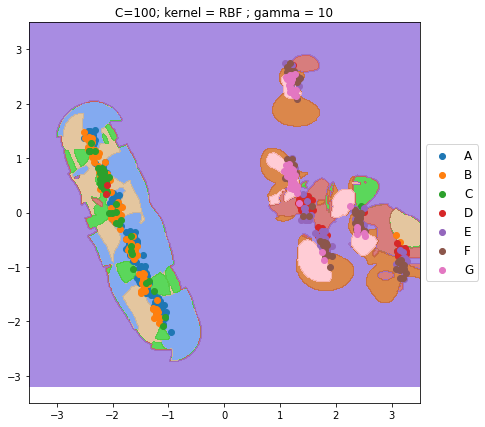

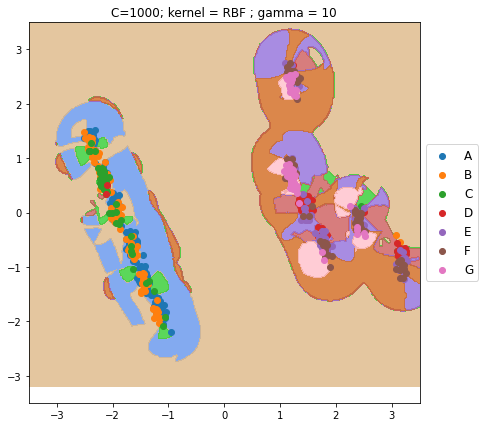

In [84]:
C_list = [0.1, 1, 10, 100, 1000]
for C in C_list:
    svc = SVC(kernel='rbf', gamma=10, C=C).fit(X_train_acp, y_train_nb)
    plot_svc(svc, 'C=' + str(C) + '; kernel = RBF ; gamma = 10')

On peut voir qu'une valeur élevée de C conduit à overfit les données. Le modèle avec C=10 semble être le meilleur. 


Nous pouvons maintenant récupérer le modèle polynomial et l'affiner grâce au degré du paramètre.

### Degree

In [85]:
COMPUTE = False
degrees = [1, 2, 3, 4]

if(COMPUTE==True):
    for degree in degrees:
        svc = SVC(kernel='poly', gamma=10, C=10, degree=degree).fit(X_train_acp, y_train_nb)
        plot_svc(svc, 'C=' + str(C) + '; kernel = RBF ; gamma = 10')

Nous constatons que le modèle polynomial est moins performant que le modèle avec un noyau RBF. Nous garderons alors ce noyau pour la validation croisée.

## Validation croisée

Nous allons utiliser une validation croisée pour voir si nos estimations visuelles étaient bonnes dans un premier temps et affiner les paramètres dans un second temps.

In [86]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

svc = SVC(cache_size=1000, kernel='rbf')

params={"C": [1, 5, 10, 20],
       "gamma": [5, 10, 20, 30, 40],
       "class_weight": [None, "balanced"]}

clf = GridSearchCV(estimator=svc, param_grid=params, scoring='f1_macro', n_jobs=-1)
  
clf.fit(X_train_acp, y_train_b)

classifier = clf.best_estimator_
clf.best_params_

{'C': 5, 'class_weight': 'balanced', 'gamma': 5}

In [87]:
params={"C": np.arange(1,10),
       "gamma": np.arange(6,20)}

clf = GridSearchCV(estimator=svc, param_grid=params, n_jobs=-1)
  
clf.fit(X_train_acp, y_train_b)
clf.best_params_

{'C': 3, 'gamma': 7}

Nous récupérons les hyperparamètres optimaux du SVC, nous pouvons maintenant tester ce modèle sur un jeu de données test transformé en 2 composantes principales.

## Test sur le jeu réduit en 2 composantes principales

### Préparation du test set  en transformant X_test en deux composantes principales

In [88]:
# Création du test set en supprimant les variables qualitatives
test_df = X_test.drop(X_test.columns[np.arange(6, 16)], axis = 1)
test_df.head()

Relative compactness Surface area  Wall area Roof area Overall height  \
668             -1.35233      1.57991    1.10843   1.00281             -1   
324             -1.09066     0.996305 -0.0287256  0.986061             -1   
624               2.0698     -1.75115  -0.474339  -1.47807              1   
690             0.317966    -0.475846   0.476161 -0.695707              1   
473             -1.15061      1.20098   0.543645  0.907583             -1   

    Glazing area  
668      1.28104  
324  -0.00387293  
624      1.29481  
690      1.19014  
473     0.185127

In [89]:
X2D_test = pca.transform(test_df)

print('Coefficient de determination: %.2f'
      % clf.best_estimator_.score(X2D_test, y_test_b))

Coefficient de determination: 0.61


Nos paramètres concernant l'ACP ne sont pas tout à fait conformes au test du train avec 100% d'inertie. Ces estimations nous ont permis de connaître le kernel approprié à notre jeu de données. Nous espérons avoir un meilleur score avec notre jeu de données à 100% d'intertie alors affinons notre modèle pour le jeu de données complet.

## Test sans ACP

Nous devons nous débarrasser des variables qualitatives car le SVC ne fonctionne pas bien avec ce genre de variables.

In [90]:
X_test_no_acp = X_test.drop(X_test.columns[6:], axis=1)
X_train_no_acp = X_train.drop(X_train.columns[6:], axis=1)

### Validation croisée

In [91]:
clf_no_acp = GridSearchCV(estimator=svc, 
                          param_grid={'C': np.linspace(0,1,10),'gamma': np.arange(1,10)}, 
                          n_jobs=-1,
                          cv=3)
  
clf_no_acp.fit(X_train_no_acp, y_train_b)
clf_no_acp.best_params_

{'C': 0.8888888888888888, 'gamma': 7}

In [92]:
clf_no_acp.best_estimator_.score(X_test_no_acp, y_test_b)

0.6623376623376623

Nous avons utilisé pour cet SVC des valeurs d'hyperparamètres assez différents que ceux utilisés pour le classifieur sur deux composantes principales (cf gamma et C). 

Le classifieur sur les données non modifiées nous donne de meilleurs résultats.

In [93]:
# Sauvegarde des resultats
accuracy_svc = clf_no_acp.best_estimator_.score(X_test_no_acp, y_test_b)
y_pred_svc = clf_no_acp.best_estimator_.predict(X_test_no_acp)
f1_score_svc = f1_score(y_test_b, y_pred_svc, average='macro')
f1_score_svc

0.6198211424183544

### Analyse des erreurs

<Figure size 360x360 with 0 Axes>

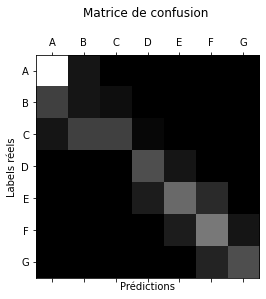

In [94]:
y_test_pred = clf_no_acp.best_estimator_.predict(X_test_no_acp)
conf_mx = confusion_matrix(y_test_b, y_test_pred)
display_conf_matrix(conf_mx)

Comme on peut le voir, il est difficile pour le classifieur de classer correctement B et C. Il confond le B avec le A et le C avec le B. 
Nous avons pu voir la difficulté pour le classifieur de bien séparer ces différents labels sur la visulation ACP lorsque nous testions différents hyperparamètres.

<Figure size 360x360 with 0 Axes>

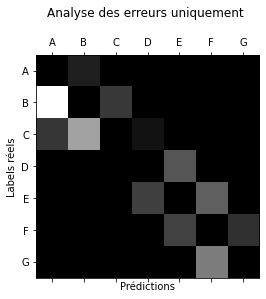

In [95]:
plot_error_analysis(conf_mx)

### Precision, recall, f1_score

In [96]:
from sklearn.metrics import precision_recall_fscore_support

precision_recall_fscore_support(y_true=y_test_b, y_pred=y_test_pred, average='macro')

(0.6471938775510203, 0.6182858807858808, 0.6198211424183544, None)

In [97]:
from sklearn.metrics import classification_report

# Print the precision and recall, among other metrics
print(classification_report(y_test_b, y_test_pred, digits=3))

              precision    recall  f1-score   support

           A      0.750     0.923     0.828        39
           B      0.200     0.214     0.207        14
           C      0.818     0.409     0.545        22
           D      0.688     0.786     0.733        14
           E      0.682     0.600     0.638        25
           F      0.607     0.708     0.654        24
           G      0.786     0.688     0.733        16

    accuracy                          0.662       154
   macro avg      0.647     0.618     0.620       154
weighted avg      0.674     0.662     0.655       154



"B" est largement la classe la plus mal classée puisqu'elle est souvent confondue par des "A" ou des "C". Cela se vérifie très bien sur la matrice de confusion, celle d'erreur et son f1-score très faible par rapport aux autres classes. Il est vrai que c'est la classe la plus mal représentée, regardons si avec une technique suréchantillonge nous pouvons améliorer les résultats.

### SVC avec duplication naïve des échantillons

In [98]:
from sklearn.metrics import f1_score
warnings.filterwarnings('ignore')


model = Pipeline([
        ('sampling', RandomOverSampler(random_state=12)),
        ('clf', SVC())
    ])

params_svc={"clf__C": np.linspace(1,5),
       "clf__gamma": np.linspace(1,5),
       "clf__class_weight": [None, "balanced"]}

svc_res = GridSearchCV(estimator=model, param_grid=params_svc, scoring='f1_macro', n_jobs=-1)
  
svc_res.fit(X_train_no_acp, y_train_b)

print(svc_res.best_estimator_.score(X_train_no_acp, y_train_b))
svc_res.best_params_

0.7296416938110749


{'clf__C': 1.9795918367346939,
 'clf__class_weight': None,
 'clf__gamma': 1.816326530612245}

Il est logique que la validation croisée "préfère" ne pas équilibré les poids des classes puisqu'elles sont déjà équilibrées par la duplication utilisée dans le pipeline. La duplication naïve des échantillons donne une bonne accuracy mais n'améliore pas le classifieur, nous allons donc garder les résultats initiaux.

### SVC avec duplication SMOTE

In [99]:
from sklearn.metrics import f1_score
warnings.filterwarnings('ignore')


model = Pipeline([
        ('sampling', SMOTE(random_state=12)),
        ('clf', SVC())
    ])

clf = GridSearchCV(estimator=model, param_grid=params_svc, scoring='f1_macro', n_jobs=-1)
  
clf.fit(X_train_no_acp, y_train_b)

print(clf.best_estimator_.score(X_train_no_acp, y_train_b))
clf.best_params_

0.7133550488599348


{'clf__C': 2.63265306122449,
 'clf__class_weight': None,
 'clf__gamma': 1.0816326530612246}

# Boosting

Nous allons utiliser trois classifieurs dits "boosting" pour estimer les classes de nos bâtiments : le gradient boosting, adaboost et le extrême gradient boosting.

##  Gradient Boosting


In [100]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier().fit(X_train, y_train_b) 

np.mean(cross_val_score(estimator=gbc, X=X_train, y=y_train_b, cv=3))

0.5716005101227483

Nous allons tester et visualiser l'effet des hyperparamètres principaux du gradient boosting avant de procéder à la validation croisée.

### Learning rate

In [101]:
# fonction qui va permettre de visualiser les résultats f1 score du train set 
#et du test set en fonction de l'augementation du paramètre en question
def plot_f1_scores(train_results, test_results, parameter, parameter_name):
    line1, = plt.plot(parameter, train_results, 'b', label='Train f1 score')
    line2, = plt.plot(parameter, test_results, 'r', label='Validation f1 score')
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel('f1_score')
    plt.xlabel(parameter_name)
    plt.show()  

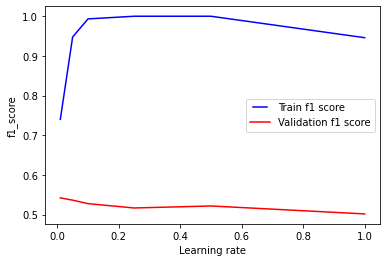

In [102]:
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from matplotlib.legend_handler import HandlerLine2D
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict
import numpy as np

learning_rates = [1, 0.5, 0.25, 0.1, 0.05, 0.01]

train_results = []
test_results = []

for eta in learning_rates:
    model = GradientBoostingClassifier(learning_rate=eta)
    model.fit(X_train, y_train_b)
    
    train_pred = model.predict(X_train)   
    f1_score_train = f1_score(y_train_b, train_pred, average='macro')
    train_results.append(f1_score_train)  
    
    valid_pred = cross_val_predict(X=X_train, y=y_train_b, estimator=model, cv=5)   
    f1_score_valid= f1_score(y_train_b, valid_pred, average='macro')
    test_results.append(f1_score_valid)
    
plot_f1_scores(train_results, test_results, parameter=learning_rates, parameter_name='Learning rate')

On peut observer sur ce graphique que le modèle s'adapte trop à l'augementation du taux d'apprentissage. Le taux d'apprentissage optimal est inférieur à 0,3.

### N estimator

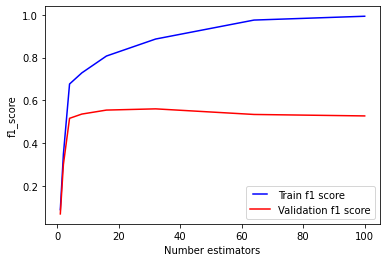

In [103]:
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100]
train_results = []
test_results = []

for estimator in n_estimators:
    model = GradientBoostingClassifier(n_estimators=estimator, learning_rate=0.1)
    model.fit(X_train, y_train_b)
    
    train_pred = model.predict(X_train)   
    f1_score_train = f1_score(y_train_b, train_pred, average='macro')
    train_results.append(f1_score_train)  
    
    valid_pred = cross_val_predict(X=X_train, y=y_train_b, estimator=model, cv=5)   
    f1_score_valid= f1_score(y_train_b, valid_pred, average='macro')
    test_results.append(f1_score_valid)

plot_f1_scores(train_results, test_results, parameter=n_estimators, parameter_name='Number estimators')

Le paramètre n_estimators représente le nombre d'arbres dans la forêt. Le n_estimateur optimal se situe entre 10 et 40.

### Max depth

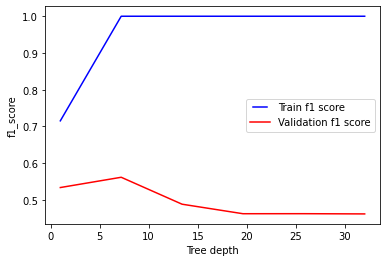

In [104]:
max_depths = np.linspace(1, 32, 6, endpoint=True)
train_results = []
test_results = []

for max_depth in max_depths:
    model = GradientBoostingClassifier(max_depth=max_depth)
    model.fit(X_train, y_train_b)
    
    train_pred = model.predict(X_train)   
    f1_score_train = f1_score(y_train_b, train_pred, average='macro')
    train_results.append(f1_score_train)  
    
    valid_pred = cross_val_predict(X=X_train, y=y_train_b, estimator=model, cv=5)   
    f1_score_valid= f1_score(y_train_b, valid_pred, average='macro')
    test_results.append(f1_score_valid)
    
plot_f1_scores(train_results, test_results, parameter=max_depths, parameter_name='Tree depth')

Le paramètre max_depth représente la profondeur maximale des arbres. Ce paramètre paraît optimal lorsqu'il vaut entre 5 et 10. Passé cette valuer, le modèle overfit les données.

### Max features

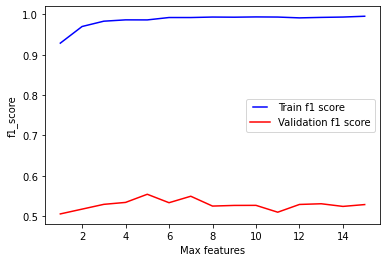

In [105]:
max_features = list(range(1,X_train.shape[1]))
train_results = []
test_results = []
for max_feature in max_features:
    model = GradientBoostingClassifier(max_features=max_feature)
    model.fit(X_train, y_train_b)   
    
    train_pred = model.predict(X_train) 
    f1_score_train = f1_score(y_train_b, train_pred, average='macro')
    train_results.append(f1_score_train)  
    
    valid_pred = cross_val_predict(X=X_train, y=y_train_b, estimator=model, cv=5)   
    f1_score_valid= f1_score(y_train_b, valid_pred, average='macro')
    test_results.append(f1_score_valid)
    
plot_f1_scores(train_results, test_results, parameter=max_features, parameter_name='Max features')

Le paramètre max features est le nombre de variables différentes utilisées pour construire les arbres. La valeur optimale de ce paramètre est située entre  6 et 8.

### Min samples leaf

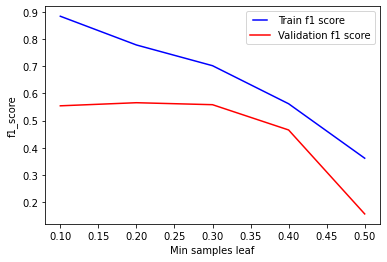

In [106]:
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
    model = GradientBoostingClassifier(min_samples_leaf=min_samples_leaf)
    model.fit(X_train, y_train_b)
    
    train_pred = model.predict(X_train)
    f1_score_train = f1_score(y_train_b, train_pred, average='macro')
    train_results.append(f1_score_train)  
    
    valid_pred = cross_val_predict(X=X_train, y=y_train_b, estimator=model, cv=5)   
    f1_score_valid= f1_score(y_train_b, valid_pred, average='macro')
    test_results.append(f1_score_valid)
    
plot_f1_scores(train_results, test_results, parameter=min_samples_leafs, parameter_name='Min samples leaf')

### Création du classifieur par validation croisée

In [107]:
from sklearn.model_selection import GridSearchCV

COMPUTE = False
model = GradientBoostingClassifier()
params = {'learning_rate':list(np.linspace(0.01, 0.3, 5)),
          'n_estimators':list(np.arange(10,40, 6)), 
          'max_features':list(np.arange(3,10)),
          'max_depth': list(np.arange(1,10, 5)),
          'min_samples_leaf': list(np.linspace(0.05, 0.35, 5))
         }

grid = GridSearchCV(estimator=model,
                    param_grid=params,
                   scoring='f1_macro')

if COMPUTE:
    grid.fit(X_train, y_train_b)
    grid.best_params_

In [108]:
import pickle

filename = 'Models/sgb.sav'
# pickle.dump(grid.best_estimator_, open(filename, 'wb'))

In [109]:
from sklearn.model_selection import cross_val_score

loaded_model = pickle.load(open(filename, 'rb'))
np.mean(cross_val_score(loaded_model, X_test, y_test_b))

0.5447311827956989

## Adaboost

Nous allons essayé d'utiliser Adaboost sans optimiser de paramètres pour voir si cet algorithme est prometteur.

In [110]:
from sklearn.ensemble import AdaBoostClassifier

# Decision Tree Regressor by default
abc = AdaBoostClassifier(n_estimators=50)

model = abc.fit(X_train, y_train_b)

In [111]:
abc.score(X_test, y_test_b)

0.2987012987012987

Au vu du score que ce classficateur obtient, nous n'en attendons pas beaucoup. Nous allons alors essayé une validation croisée directement pour voir si en optimisant les hyperparamètres nous pouvons avoir un estimateur bien meilleur mais nous n'attendons pas beaucoup de ce modèle.

In [112]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV


abc = AdaBoostClassifier()

grid = GridSearchCV(estimator = abc,
                   param_grid={'algorithm':['SAMME', 'SAMME.R'],
                               'n_estimators':np.arange(1,50,10),
                               'learning_rate': np.arange(0.000001, 1, 10)},
                   cv=3,
                   scoring='f1_macro')

grid.fit(X_train, y_train_b)
grid.best_estimator_

AdaBoostClassifier(algorithm='SAMME', learning_rate=1e-06, n_estimators=1)

In [113]:
from sklearn.model_selection import cross_val_score

cross_val_score(grid.best_estimator_, X_train, y_train_b, cv=3)

array([0.41463415, 0.4097561 , 0.41176471])

En regardant l'accuracy, on déduit qu'Adaboost n'est pas du tout performant dans notre ensemble de données. Nous savons que ce modèle est très sensible aux données bruitées et aux valeurs aberrantes. Par conséquent, ce modèle n'est pas adapté à ce cas. Nous allons donc garder le classifiteur à gradient de boosting pour faire le test.

### Test

In [114]:
gbc = loaded_model
y_test_pred = gbc.predict(X_test)
print(classification_report(y_test_b, y_test_pred, digits=3))

              precision    recall  f1-score   support

           A      0.739     0.872     0.800        39
           B      0.133     0.143     0.138        14
           C      0.909     0.455     0.606        22
           D      0.688     0.786     0.733        14
           E      0.571     0.640     0.604        25
           F      0.481     0.542     0.510        24
           G      0.818     0.562     0.667        16

    accuracy                          0.617       154
   macro avg      0.620     0.571     0.580       154
weighted avg      0.644     0.617     0.615       154



Il est évident que le classifieur est en difficulté pour prédire la classe "B". C'est surement parce que cette classe est sous-représentée, nous pouvons utiliser la duplication déchantillons pour corriger ce problème même si elle n'a pas bien fait ses preuve jusqu'ici.

In [115]:
gbc.score(X_test, y_test_b)

0.6168831168831169

In [116]:
# Sauvegarde des resultats
accuracy_gbc = loaded_model.score(X_test, y_test_b)
y_pred_gbc = loaded_model.predict(X_test)
f1_score_gbc = f1_score(y_test_b, y_pred_gbc, average='macro')

### Analyse d'erreurs

In [117]:
conf_mx = compute_conf_matrix(gbc, X_test, y_test_b)

<Figure size 360x360 with 0 Axes>

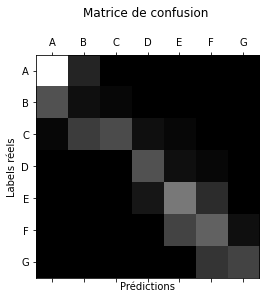

In [118]:
display_conf_matrix(conf_mx)

Le modèle classifie très bien les classes "A" et "F".

<Figure size 360x360 with 0 Axes>

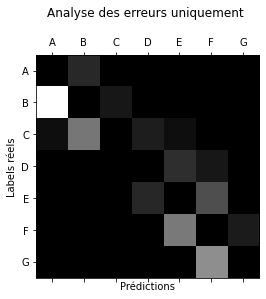

In [119]:
plot_error_analysis(conf_mx)

Ce modèle a du mal à bien classer la classe B. On peut remarquer que ce classifieur est proche d'avoir de très bons résultats car les échantillons mal classés sont presque toujours classés dans la classe la plus proche.

### Duplication d'échantillons naïve

In [120]:
from sklearn.metrics import f1_score
warnings.filterwarnings('ignore')


model = Pipeline([
        ('sampling', RandomOverSampler(random_state=12)),
        ('clf', GradientBoostingClassifier())
    ])

params = {'clf__learning_rate':list(np.linspace(0.01, 0.3, 5)),
          'clf__n_estimators':list(np.arange(10,40, 6)), 
          'clf__max_features':list(np.arange(3,10)),
          'clf__max_depth': list(np.arange(1,10, 5)),
          'clf__min_samples_leaf': list(np.linspace(0.05, 0.35, 5))
         }

clf = GridSearchCV(estimator=model, param_grid=params, scoring='f1_macro', n_jobs=-1)
  
clf.fit(X_train, y_train_b)

clf.best_estimator_.score(X_test, y_test_b)

0.6558441558441559

Ce classifieur obtient des performances similaires au classifieur initial. Nous n'irons pas plus loin en essayant une duplication SMOTE étant donné que ce type d'oversampling n'a pas fait ses preuves jusqu'ici et que le temps de clacul est conséquent pour faire une validation croisée sur ce model.

## XGBoost

Nous allons utiliser l'algorithme XGBoost, en général très performant. Nous n'allons pas réexpliquer et illustrer tous les hypermparamètres que nous avons vu lors de l'implémentation du gradient boosting. Le seul aramètre utilisé que nous n'avons pas vu est "gamma". "Gamma" représente la réduction minimale des pertes requise pour effectuer une nouvelle partition sur un nœud de l'arbre.

La librairie XGBoost fonctionne seulement avec des varialbes nuémriques, nous allons donc transformer nos "one hot encoder" en variables numériques. Nous allons également transformer les labels en chiffres.

In [121]:
data_xgboost = dataset_df.copy()

X_train_XG, X_test_XG, y_train_r_XG, y_test_r_XG = train_test_split(data_xgboost[data_xgboost.columns[0:16]], data_xgboost['Energy'], test_size=0.20, random_state=42)
_, _, y_train_b_XG, y_test_b_XG = train_test_split(dataset_df[data_xgboost.columns[0:16]], data_xgboost['Energy efficiency'], test_size=0.20, random_state=42) 

X_train_XG = X_train_XG.apply(pd.to_numeric, errors='coerce')
X_test_XG = X_test_XG.apply(pd.to_numeric, errors='coerce')

In [122]:
y_train_nb = y_train_b_XG.replace(["A","B","C", "D", "E", "F", "G"], np.arange(1,8))
y_test_nb = y_test_b_XG.replace(["A","B","C", "D", "E", "F", "G"], np.arange(1,8))

Nous allons directement procéder à une validation croisée avec les principaux hyperparamètres du model.

In [123]:
import xgboost as xgb

params_xg ={'n_estimators': np.arange(10, 50, 5),
            'max_depth': np.arange(2,12,2), 
            'learning_rate': [0.001, 0.003, 0.01, 0.03, 0.1, 0.3],
            'gamma': np.linspace(0.00001, 0.01, 5)}


xg = GridSearchCV(estimator=xgb.XGBClassifier(), param_grid=params_xg, scoring='f1_macro', n_jobs=-1)

xg.fit(X_train_XG,y_train_nb)

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None...
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameters=None,
                                     verbosity=None),
             n_j

In [124]:
xg.best_params_

{'gamma': 0.005005, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 35}

In [125]:
# Sauvegarde des resultats
accuracy_xgb = xg.best_estimator_.score(X_test_XG, y_test_nb)
y_pred_xgb = xg.best_estimator_.predict(X_test_XG)
f1_score_xgb = f1_score(y_test_nb, y_pred_xgb, average='macro')

### Analyse d'erreurs

In [126]:
print(classification_report(y_test_nb, y_pred_xgb, digits=3))

              precision    recall  f1-score   support

           1      0.767     0.846     0.805        39
           2      0.222     0.286     0.250        14
           3      0.846     0.500     0.629        22
           4      0.706     0.857     0.774        14
           5      0.583     0.560     0.571        25
           6      0.462     0.500     0.480        24
           7      0.692     0.562     0.621        16

    accuracy                          0.617       154
   macro avg      0.611     0.587     0.590       154
weighted avg      0.638     0.617     0.619       154



Le extrem gradient boosting est un petit peu meilleur que le gradient boosting.

<Figure size 360x360 with 0 Axes>

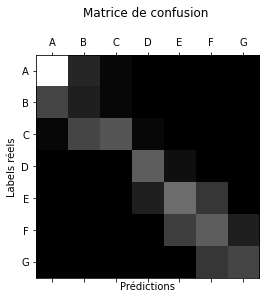

In [127]:
conf_mx = compute_conf_matrix(xg.best_estimator_, X_test_XG, y_test_nb)
display_conf_matrix(conf_mx)

# Conclusion

Pour conclure la partie classification des bâtiments sur Python, nous allons afficher les meilleurs résultats que nous avons obtenus avec les différents classifieurs que nous avons essayé.

In [128]:
d = {'Logistic Régression': [accuracy_lr, f1_score_lr],
     'Arbre de décision': [accuracy_dtc, f1_score_dtc],
     'Random forest': [accuracy_rf, f1_score_rf],
     'SVC ': [accuracy_svc, f1_score_svc],
     'Gradient boosting': [accuracy_gbc, f1_score_gbc],
     'Extrem Gradient boosting': [accuracy_xgb, f1_score_xgb]}

results = pd.DataFrame(data=d, index=['Accuracy', 'f1_score'])
results

Logistic Régression  Arbre de décision  Random forest      SVC   \
Accuracy             0.571429           0.642857       0.636364  0.662338   
f1_score             0.534840           0.622932       0.607740  0.619821   

          Gradient boosting  Extrem Gradient boosting  
Accuracy           0.616883                  0.616883  
f1_score           0.579653                  0.589966

In [129]:
# Sauvegarde des résultats dans un fichier CSV
results.to_csv('Results/classification.csv', index=True)

Pour la classification, nous pouvons conclure que les modèles les plus performants sont :
- L'extrem gradient boosting.
- Le random forest.
- L'arbre de décision.

Comme nous avons pu le voir tout au long de notebook grâce à la duplication de données, l'ajout de données n'améliorera sûrement pas les classifieurs. Les classifieurs ont du mal à obtenir de bons résultats à cause du bruit ajoutés sur les données.

Nous avons remarqué que la lcasse "B" était très difficile à prédire pour les différents modèles. Nous pouvions penser que c'était car elle était sous représenté, nous avons essayé de corriger le probème en duplicant les données. Cela n'a pas fonctionné. Nous avons cependant deux explications à ce problème, la première vient du fait qu'il est difficile de trouver une séparation claire entre les labels "B" et "A", "B" et "C" -> nous visualisons cela sur l'ACP en 2 composantes principales. La seconde raison (liée à la première et à sa sous représentation) vient du fait que cette classe est délimitée par seulement 5 valeurs énergétiques 30 à 35 contrairement à "A" qui a par exemple un intervalle de 30 valeurs énergétiques (ce qui explique en partie les forts f1_score qu'obtient cette classe).

Sur la plupart matrices de confusion qui analysent seulement les erreurs, nous remarquons que nos classifieurs sont plutôt bons dans le sens où les erreurs sont faites avec les classes voisines (par exemple le classifieur confond le "E" et le "F"). Il n'y a jamais de confusion entre une classe "A" et "E" par exemple. Nous pouvons même aller plus loin en disant qu'il y a très rarement des confusion entre les deux groupes de classes montrées par l'ACP ("A", "B", "C" et "D", "E", "F", "G").

In [130]:
# Sauvegarde des résultats dans un fichier CSV
results.to_csv('Results/classification.csv', index=True)